[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/state-schema.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239426-lesson-1-state-schema)

# State Schema 状态模式

## 回顾
在模块 1 中，我们打下了基础！我们构建了一个能够实现以下功能的代理：

- `act` - 让模型调用特定工具
- `observe` - 观察工具的输出，传递回模型
- `reason` - 让模型对工具输出进行推理，以决定接下来要做什么（例如，调用另一个工具或直接响应）
- `persist state` - 使用内存检查点器支持有中断的长时间对话

此外，我们展示了如何在 LangGraph Studio 本地运行代理，或使用 LangGraph Cloud 部署代理。

## 目标
在本模块中，我们将深入理解状态和记忆。

首先，我们来回顾几种定义状态架构的方法。

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph

## Schema 模式
当我们定义一个 LangGraph 的 StateGraph 时，我们会使用一个`状态模式`[`state schema`](https://langchain-ai.github.io/langgraph/concepts/low_level/#state)。

状态模式（架构） State Schema，表示 graph 将使用的数据的结构和类型。

所有节点都需要通过该`schema模式`进行通信。

LangGraph 提供了灵活性，支持使用多种 Python `类型`[`types`](https://docs.python.org/3/library/stdtypes.html#type-objects) 和验证方法来定义状态模式！

## TypedDict: 一般使用
正如我们在模块 1 中提到的，可以使用 Python `typing` 模块中的 `TypedDict` 类。

它允许你指定键及其对应的值类型。

但需要注意的是，这些只是类型提示。

它们可被静态类型检查器（如 [mypy](https://github.com/python/mypy)）或 IDE 使用，以在代码运行前捕获潜在的类型相关错误。

但它们在运行时并不会强制执行！

In [2]:
from typing_extensions import TypedDict

class TypedDictState(TypedDict):
    foo: str
    bar: str

Literal: 限定文本型答案的有限选项，比如 "Yes" or "No".

对于更具体的值约束，你可以使用类似 Literal 的类型提示。

例如，mood 只能是 "happy" 或 "sad"。

In [3]:
from typing import Literal

class TypedDictState(TypedDict):
    name: str
    mood: Literal["happy","sad"]

我们可以通过将定义的状态类（例如，这里是 `TypedDictState`）传递给 `StateGraph`，在 LangGraph 中使用它。

此外，我们可以将每个状态键视为图中的一个“通道”。

正如在模块 1 中讨论的那样，我们会在每个节点中`override 覆盖`指定键或“通道”的值。

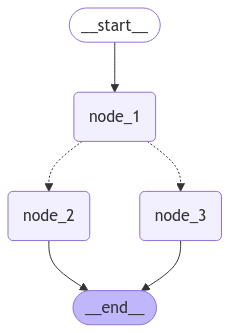

In [4]:
import random
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

def node_1(state):
    print("---Node 1---")
    return {"name": state['name'] + " is ... "}

def node_2(state):
    print("---Node 2---")
    return {"mood": "happy"}

def node_3(state):
    print("---Node 3---")
    return {"mood": "sad"}

def decide_mood(state) -> Literal["node_2", "node_3"]:
        
    # Here, let's just do a 50 / 50 split between nodes 2, 3
    if random.random() < 0.5:

        # 50% of the time, we return Node 2
        return "node_2"
    
    # 50% of the time, we return Node 3
    return "node_3"

# Build graph
builder = StateGraph(TypedDictState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

由于我们的状态是一个字典 (state=字典)，我们只需通过字典调用图表即可为状态中的 name 键设置初始值。

In [5]:
graph.invoke({"name":"Lance"})

---Node 1---
---Node 3---


{'name': 'Lance is ... ', 'mood': 'sad'}

## Dataclass：不太推荐

Python 的 `数据类`[`dataclasses`](https://docs.python.org/3/library/dataclasses.html)  提供了另一种定义`结构化数据`[`structured data`](https://www.datacamp.com/tutorial/python-data-classes) 的方法。

数据类为创建主要用于存储数据的类，提供了一种简洁的语法。

In [7]:
from dataclasses import dataclass

@dataclass
class DataclassState:
    name: str
    mood: Literal["happy","sad"]

要访问 `dataclass` 的键，我们只需修改 `node_1` 中使用的下标方式：

对于 `dataclass` 状态，我们使用 `state.name`，而不是像上面的 TypedDict 使用 `state["name"]`。
你会注意到一个稍显奇怪的地方：在每个节点中，我们仍然返回一个字典来执行状态更新。

这是因为 LangGraph 会分别存储状态对象的每个键。

节点返回的对象只需要包含与状态中键（属性）匹配的键即可！

在这种情况下，`dataclass` 中有键 `name`，因此我们可以像使用 `TypedDict` 状态时一样，通过从节点传递一个字典来更新它。

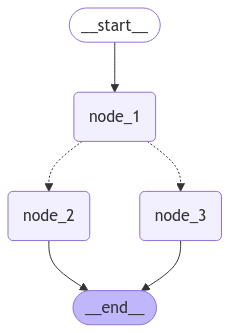

In [8]:
def node_1(state):
    print("---Node 1---")
    return {"name": state.name + " is ... "}

# Build graph
builder = StateGraph(DataclassState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

我们通过 `dataclass` 调用来设置状态中每个键/通道的初始值！

In [9]:
graph.invoke(DataclassState(name="Lance",mood="sad"))

---Node 1---
---Node 3---


{'name': 'Lance is ... ', 'mood': 'sad'}

## Pydantic: 推荐使用！

如前所述，`TypedDict` 和 `dataclasses` 提供的是类型提示，但在运行时并`不会强制类型`。

这意味着你可能会赋予无效的值而不会报错！

例如，即使类型提示指定了 `mood: list[Literal["happy", "sad"]]`，我们仍然可以将 `mood` 设置为 `mad`。

In [8]:
dataclass_instance = DataclassState(name="Lance", mood="mad")

[Pydantic](https://docs.pydantic.dev/latest/api/base_model/)  是一个使用 Python 类型注解进行数据验证和设置管理的库。

它特别适合在 LangGraph 中定义状态架构 [defining state schemas in LangGraph](https://langchain-ai.github.io/langgraph/how-tos/state-model/)，因为它具备强大的验证功能。

Pydantic 可以在运行时执行验证，以检查数据是否符合指定的类型和约束。

In [10]:
from pydantic import BaseModel, field_validator, ValidationError

class PydanticState(BaseModel):
    name: str
    mood: str # "happy" or "sad" 

    @field_validator('mood')
    @classmethod
    def validate_mood(cls, value):
        # Ensure the mood is either "happy" or "sad"
        if value not in ["happy", "sad"]:
            raise ValueError("Each mood must be either 'happy' or 'sad'")
        return value

try:
    state = PydanticState(name="John Doe", mood="mad")
except ValidationError as e:
    print("Validation Error:", e)

Validation Error: 1 validation error for PydanticState
mood
  Value error, Each mood must be either 'happy' or 'sad' [type=value_error, input_value='mad', input_type=str]
    For further information visit https://errors.pydantic.dev/2.10/v/value_error


我们可以在 LangGraph 中，非常丝滑地使用 `PydanticState`。

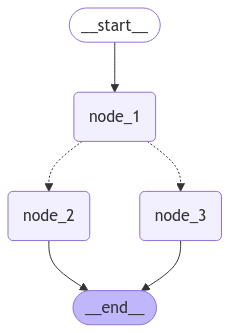

In [11]:
# Build graph
builder = StateGraph(PydanticState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
graph.invoke(PydanticState(name="Lance",mood="sad"))

---Node 1---
---Node 2---


{'name': 'Lance is ... ', 'mood': 'happy'}

In [ ]:
# END